<a href="https://colab.research.google.com/github/Seo-Jeong-Lee/tmp/blob/main/Keras_CNN_%2B_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [ ]:
import numpy as np
import random
import os
import math

from glob import glob
import pandas as pd
import cv2
from tqdm.auto import tqdm

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
import keras

In [ ]:
import pandas as pd
import lightgbm as lgb

## Hyperparameters Setting

## Fix RandomSeed

## Data Pre-processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dpath = "/content/drive/MyDrive/open/"

In [ ]:
features = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
       '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하',
       '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']

In [ ]:
train_csv_files = sorted(glob(dpath + "/train/*/meta/*.csv"))

In [ ]:
results = []
for train_csv_file in tqdm(train_csv_files):
    df_csv = pd.read_csv(train_csv_file)
    image = os.path.split(train_csv_file)[1].split(".")[0]
    df_csv["image"] = image
    results.append(df_csv)

  0%|          | 0/1592 [00:00<?, ?it/s]

In [ ]:
print(results[0].info())
print(results[9].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           1440 non-null   object 
 1   내부온도관측치      1440 non-null   float64
 2   외부온도관측치      1440 non-null   float64
 3   내부습도관측치      1440 non-null   float64
 4   외부습도관측치      1149 non-null   float64
 5   CO2관측치       1440 non-null   float64
 6   EC관측치        1440 non-null   float64
 7   최근분무량        1440 non-null   float64
 8   화이트 LED동작강도  1387 non-null   float64
 9   레드 LED동작강도   1389 non-null   float64
 10  블루 LED동작강도   860 non-null    float64
 11  냉방온도         1416 non-null   float64
 12  냉방부하         1416 non-null   float64
 13  난방온도         1416 non-null   float64
 14  난방부하         1416 non-null   float64
 15  총추정광량        1416 non-null   float64
 16  백색광추정광량      1416 non-null   float64
 17  적색광추정광량      1416 non-null   float64
 18  청색광추정광량      0 non-null      float64
 19  image 

냉방온도부터 적색광추정광량은 동일한 행에서 결측치 발생

각 케이스마다 해당되는 행은 다른데 61분 간격으로 결측치가 발생함

** 일단은 바로 이전 값으로 대체



In [ ]:
results[0][results[0]["냉방온도"].isnull()]

,시간,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,image
25,2021-05-07 03:11,18.400000,41.099998,78.099998,0.0,585.0,18.600000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CASE01_01
86,2021-05-07 04:12,18.100000,37.900002,79.099998,0.0,582.0,18.299999,0.0,201.0,201.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CASE01_01
147,2021-05-07 05:13,18.299999,37.500000,78.300003,0.0,585.0,18.400000,0.0,201.0,201.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CASE01_01
208,2021-05-07 06:14,18.600000,40.000000,82.599998,0.0,579.0,18.600000,0.0,201.0,201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CASE01_01
269,2021-05-07 07:15,19.700001,42.299999,76.300003,0.0,504.0,19.900000,0.0,201.0,201.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CASE01_01
330,2021-05-07 08:16,22.799999,48.000000,75.900002,0.0,421.0,22.200001,0.0,201.0,201.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CASE01_01
391,2021-05-07 09:17,26.600000,48.500000,79.300003,NaN,376.0,23.600000,0.0,201.0,201.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CASE01_01
452,2021-05-07 10:18,28.799999,55.500000,77.099998,0.0,372.0,21.799999,0.0,201.0,201.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CASE01_01
512,2021-05-07 11:18,28.400000,59.500000,75.900002,0.0,391.0,21.100000,0.0,201.0,201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CASE01_01
573,2021-05-07 12:19,27.600000,64.800003,76.199997,0.0,401.0,19.900000,0.0,201.0,201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CASE01_01


In [ ]:
for i in range(len(results)):
    results[i][features[-2]].fillna(method='ffill', inplace=True)
    results[i][features[-3]].fillna(method='ffill', inplace=True)
    results[i][features[-4]].fillna(method='ffill', inplace=True)
    results[i][features[-5]].fillna(method='ffill', inplace=True)
    results[i][features[-6]].fillna(method='ffill', inplace=True)
    results[i][features[-7]].fillna(method='ffill', inplace=True)
    results[i][features[-8]].fillna(method='ffill', inplace=True)

results[0][results[0]["냉방온도"].isnull()]

,시간,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,image


시계열인만큼 (아마) 이전이나 다음 행 평균치로 바꾸면 좋을텐데 아직은 모르겠으니 다 이전 행으로 채워줍니다!

청색광추정광량 같은 경우 거의 다 결측치, 총추정광량에서 나머지 광량을 빼주면 나오므로 해당 변수 값으로 대체

In [ ]:
for i in range(len(results)):
    results[i][features[-1]] = results[i][features[-4]] - results[i][features[-3]] - results[i][features[-2]]
    results[i].fillna(method='ffill', inplace=True)
    results[i].fillna(method='bfill', inplace=True)

results[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           1440 non-null   object 
 1   내부온도관측치      1440 non-null   float64
 2   외부온도관측치      1440 non-null   float64
 3   내부습도관측치      1440 non-null   float64
 4   외부습도관측치      1440 non-null   float64
 5   CO2관측치       1440 non-null   float64
 6   EC관측치        1440 non-null   float64
 7   최근분무량        1440 non-null   float64
 8   화이트 LED동작강도  1440 non-null   float64
 9   레드 LED동작강도   1440 non-null   float64
 10  블루 LED동작강도   1440 non-null   float64
 11  냉방온도         1440 non-null   float64
 12  냉방부하         1440 non-null   float64
 13  난방온도         1440 non-null   float64
 14  난방부하         1440 non-null   float64
 15  총추정광량        1440 non-null   float64
 16  백색광추정광량      1440 non-null   float64
 17  적색광추정광량      1440 non-null   float64
 18  청색광추정광량      1440 non-null   float64
 19  image 

** 아래는 아직 해결 못한 전처리

CASE08~09, 59(58과 중복)는 데이터 없음

최근분무량 데이터의 경우 CASE10~14는 ‘최근분무량’이 아닌 ‘일간누적분무량’이라고 함(results[115]부터)

In [ ]:
# 아래 전처리를 하기 전에 image와 시간 열을 제외한 다른 데이터를 만들어줍니다!
# 이 위에서만 결측치 처리와 데이터 수정

train_csv = []

for i in range(len(results)):
    train_csv_ing = results[i][features].copy()
    train_csv.append(train_csv_ing)

In [ ]:
len(train_csv)

1592

In [ ]:
# MinMaxScaling
min_val = []
max_val = []

for i in range(len(results)):
    max_val_ing, min_val_ing = train_csv[i].max(), train_csv[i].min()
    max_val.append(max_val_ing)
    min_val.append(min_val_ing)
    train_csv[i] = (train_csv[i] - min_val[i]) / (max_val[i] - min_val[i])
    train_csv[i] = train_csv[i].replace(np.NAN, 0)

In [ ]:
train_csv[0]

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
0,0.100000,0.337766,0.571428,0.0,0.932773,0.361446,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.429091,0.0,0.0,0.0,0.0
1,0.100000,0.337766,0.575630,0.0,0.945378,0.385542,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.429091,0.0,0.0,0.0,0.0
2,0.100000,0.332447,0.579832,0.0,0.953782,0.373494,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.429091,0.0,0.0,0.0,0.0
3,0.091667,0.327128,0.579832,0.0,0.941176,0.385542,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.412588,0.0,0.0,0.0,0.0
4,0.100000,0.329787,0.579832,0.0,0.936975,0.421687,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.429091,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.000000,0.510638,0.231092,0.0,0.873950,0.012048,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.231049,0.0,0.0,0.0,0.0
1436,0.000000,0.510638,0.256302,0.0,0.890756,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.231049,0.0,0.0,0.0,0.0
1437,0.000000,0.510638,0.277311,0.0,0.899160,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.231049,0.0,0.0,0.0,0.0
1438,0.000000,0.510638,0.319328,0.0,0.899160,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.231049,0.0,0.0,0.0,0.0


In [ ]:
# 표준화(위 코드로 전처리한 경우 안해도 됨, 보통은 위를 많이 진행한다고 함)
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
import natsort

In [ ]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    for case_name in natsort.natsorted(os.listdir(data_dir)):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(natsort.natsorted(glob(os.path.join(current_path, 'image', '*.jpg'))))
            img_path_list.extend(natsort.natsorted(glob(os.path.join(current_path, 'image', '*.png'))))
            
            # get label
            label_df = pd.read_csv(current_path+'/label.csv')
            label_list.extend(label_df['leaf_weight'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    return img_path_list

# 데이터 가져오는 함수 정의

In [ ]:
all_img_path, all_label = get_train_data(dpath + 'train')
test_img_path = get_test_data(dpath + 'test')

In [ ]:
all_img_path

['/content/drive/MyDrive/open/train/CASE01/image/CASE01_01.png',
 '/content/drive/MyDrive/open/train/CASE01/image/CASE01_02.png',
 '/content/drive/MyDrive/open/train/CASE01/image/CASE01_03.png',
 '/content/drive/MyDrive/open/train/CASE01/image/CASE01_04.png',
 '/content/drive/MyDrive/open/train/CASE01/image/CASE01_05.png',
 '/content/drive/MyDrive/open/train/CASE01/image/CASE01_06.png',
 '/content/drive/MyDrive/open/train/CASE01/image/CASE01_07.png',
 '/content/drive/MyDrive/open/train/CASE01/image/CASE01_08.png',
 '/content/drive/MyDrive/open/train/CASE01/image/CASE01_09.png',
 '/content/drive/MyDrive/open/train/CASE02/image/CASE02_01.png',
 '/content/drive/MyDrive/open/train/CASE02/image/CASE02_02.png',
 '/content/drive/MyDrive/open/train/CASE02/image/CASE02_03.png',
 '/content/drive/MyDrive/open/train/CASE02/image/CASE02_04.png',
 '/content/drive/MyDrive/open/train/CASE02/image/CASE02_05.png',
 '/content/drive/MyDrive/open/train/CASE02/image/CASE02_06.png',
 '/content/drive/MyDrive/

In [ ]:
all_label

[49.193,
 59.764,
 72.209,
 85.737,
 102.537,
 123.359,
 156.149,
 174.931,
 187.523,
 194.662,
 198.366,
 196.788,
 197.342,
 200.202,
 201.48,
 197.409,
 185.996,
 165.73,
 153.971,
 142.744,
 11.337,
 15.728,
 21.492,
 27.091,
 32.278,
 57.147,
 73.89,
 90.729,
 110.563,
 129.551,
 156.908,
 194.027,
 225.75,
 247.918,
 269.766,
 280.068,
 283.626,
 286.22,
 295.744,
 289.846,
 287.79,
 297.819,
 304.211,
 307.767,
 308.377,
 309.886,
 315.078,
 308.265,
 315.785,
 325.093,
 322.216,
 329.69,
 1.472,
 1.991,
 2.658,
 3.315,
 4.253,
 5.318,
 6.035,
 6.942,
 9.218,
 13.001,
 16.668,
 21.961,
 27.872,
 35.142,
 41.602,
 48.623,
 58.904,
 69.522,
 85.606,
 94.048,
 56.841,
 99.48,
 82.743,
 0.118,
 0.5,
 0.971,
 1.371,
 1.395,
 1.956,
 2.283,
 4.698,
 7.327,
 10.241,
 15.189,
 165.769,
 213.404,
 262.77,
 321.295,
 333.104,
 429.758,
 395.947,
 358.881,
 426.32,
 0.486,
 0.869,
 1.273,
 1.748,
 2.36,
 3.329,
 4.571,
 6.537,
 9.419,
 14.134,
 19.147,
 232.012,
 247.298,
 263.449,
 300.82

## Train / Validation Split

In [ ]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(all_img_path)*0.8)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [ ]:
train_csv_data = train_csv[:train_len]
vali_csv_data = train_csv[train_len:]

## CustomDataset

In [ ]:
img_size = 128

In [ ]:
def decode_img(img):
    # 압축된 형식의 string을 3D uint8 tensor 로 변환
    img = tf.image.decode_png(img, channels=3)
    # `convert_image_dtype` 사용:  float형의 데이터를 [0, 1] 범위로 변환.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 이미지 리사이즈.
    return tf.image.resize(img, [img_size, img_size])

# 출처: [tf] 이미지 파일 로드 하기|작성자 겨울나무

In [ ]:
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [ ]:
train_images = list(map(process_path, train_img_path))
vali_images = list(map(process_path, vali_img_path))

In [ ]:
train_x = np.array(train_images)
train_y = np.array(train_label)
validation_x = np.array(vali_images)
validation_y = np.array(vali_label)

In [ ]:
train_x_csv = np.array(train_csv_data)
vali_x_csv = np.array(vali_csv_data)

In [ ]:
train_x.shape

(1273, 128, 128, 3)

In [ ]:
train_x_csv.shape

(1273, 1440, 18)

In [ ]:
train_y.shape

(1273,)

** 이 이후부터는 마음대로 하셔도 됩니다! 위는 데이터 가져온 거에요~

## Define Model Architecture

#### CNN

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=10,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(filters=8, kernel_size=3, padding="same", activation="relu")(inputs) # 위 코드 삭제 시 여기 x에 inputs 넣어주세요~
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model_C1 = keras.Model(inputs=inputs, outputs=outputs)

# 데이터 증식 별로, 여기에 adam한 게 제일 낮게 나옴

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(filters=8, kernel_size=3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(0.002))(inputs) # 위 코드 삭제 시 여기 x에 inputs 넣어주세요~
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=16, kernel_size=3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(0.002))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(0.002))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(0.002))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model_C = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_C.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 8)       216       
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 16)        1152

In [ ]:
model_C.compile(optimizer="rmsprop",
                loss="mse",
                metrics=['mae', 'mse'])

In [ ]:
callbacks_C = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

#### RNN

In [ ]:
inputs = keras.Input(shape=(1440, 18))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model_R = keras.Model(inputs, outputs)

callbacks_R = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True,
                                    monitor="val_loss")
]

model_R.compile(optimizer="rmsprop", loss="mse", metrics=["mae", "mse"])

In [ ]:
model_R.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1440, 18)]        0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                6528      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,561
Trainable params: 6,561
Non-trainable params: 0
_________________________________________________________________


## Train

In [ ]:
history_C = model_C.fit(train_x, train_y,
                        epochs=100,
                        validation_data=[validation_x, validation_y],
                        batch_size=8,
                        callbacks=callbacks_C)

Epoch 1/100
160/160 [==============================] - 26s 143ms/step - loss: 1911.4780 - mae: 26.0933 - mse: 1911.3129 - val_loss: 933.6658 - val_mae: 24.6640 - val_mse: 933.4963
Epoch 2/100
160/160 [==============================] - 21s 133ms/step - loss: 694.7717 - mae: 14.1389 - mse: 694.5988 - val_loss: 1139.3037 - val_mae: 27.8396 - val_mse: 1139.1262
Epoch 3/100
 22/160 [===>..........................] - ETA: 17s - loss: 779.6609 - mae: 14.0867 - mse: 779.4830

KeyboardInterrupt: ignored

In [ ]:
history_R = model_R.fit(train_x_csv, train_y,
                      epochs=50,
                      validation_data=[vali_x_csv, validation_y],
                      batch_size=64,
                      callbacks=callbacks_R)

Epoch 1/50
20/20 [==============================] - 53s 2s/step - loss: 17077.9551 - mae: 78.5244 - mse: 17077.9551 - val_loss: 14780.0459 - val_mae: 78.4322 - val_mse: 14780.0459
Epoch 2/50
20/20 [==============================] - 28s 1s/step - loss: 16594.7188 - mae: 76.6581 - mse: 16594.7188 - val_loss: 14459.6553 - val_mae: 77.2845 - val_mse: 14459.6553
Epoch 3/50
20/20 [==============================] - 27s 1s/step - loss: 16334.8857 - mae: 75.8315 - mse: 16334.8857 - val_loss: 14245.3232 - val_mae: 76.6039 - val_mse: 14245.3232
Epoch 4/50
20/20 [==============================] - 30s 2s/step - loss: 16149.7734 - mae: 75.3440 - mse: 16149.7734 - val_loss: 14093.8027 - val_mae: 76.1540 - val_mse: 14093.8027
Epoch 5/50
20/20 [==============================] - 28s 1s/step - loss: 16048.5039 - mae: 75.0488 - mse: 16048.5039 - val_loss: 13966.4541 - val_mae: 75.7899 - val_mse: 13966.4541
Epoch 6/50
20/20 [==============================] - 28s 1s/step - loss: 15903.1426 - mae: 74.5524 - 

KeyboardInterrupt: ignored

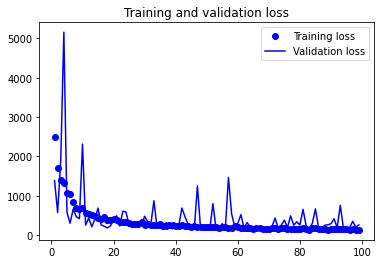

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["loss"][1:]
val_loss = history.history["val_loss"][1:]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
min(val_loss)

138.6463623046875

** 이 밑으로는 test를 위한 코드입니다! 건들이지 않으셔도 돼요~

만약 위 train 데이터 전처리를 수정했다면 아래도 똑같이 수정해주셔야 합니다!

제일 좋은 방법은 하나의 전처리 함수를 짜는 게 best

## Inference

In [ ]:
test_csv_files = sorted(glob(dpath + "/test/meta/*.csv"))

In [ ]:
results_test = []
for test_csv_file in tqdm(test_csv_files):
    df_csv = pd.read_csv(test_csv_file)
    image = os.path.split(test_csv_file)[1].split(".")[0]
    df_csv["image"] = image
    results_test.append(df_csv)

In [ ]:
for i in range(len(results_test)):
    results_test[i][features[-1]] = results_test[i][features[-4]] - results_test[i][features[-3]] - results_test[i][features[-2]]
    results_test[i].fillna(method='ffill', inplace=True)
    results_test[i].fillna(method='bfill', inplace=True)

In [ ]:
test_csv = []

for i in range(len(results_test)):
    test_csv_ing = results_test[i][features].copy()
    test_csv.append(test_csv_ing)

In [ ]:
min_val = []
max_val = []

for i in range(len(results_test)):
    max_val_ing, min_val_ing = test_csv[i].max(), test_csv[i].min()
    max_val.append(max_val_ing)
    min_val.append(min_val_ing)
    test_csv[i] = (test_csv[i] - min_val[i]) / (max_val[i] - min_val[i])
    test_csv[i] = test_csv[i].replace(np.NAN, 0)

In [ ]:
test_images = list(map(process_path, test_img_path))
test_x = np.array(test_images)

In [ ]:
test_x_csv = np.array(test_csv)

In [ ]:
test_model_C = keras.models.load_model("convnet_from_scratch.keras")
preds_C = test_model_C.predict(test_x)

test_model_R = keras.models.load_model("jena_lstm_dropout.keras")
preds_R = test_model_R.predict(test_x)

preds = preds_C * 0.9 + preds_R * 0.1

In [ ]:
for i in preds:
    i = max(i, 0)

In [ ]:
preds[0]

array([71.015236], dtype=float32)

## Submission

In [ ]:
submission = pd.read_csv(dpath + 'sample_submission.csv')
submission['leaf_weight'] = preds
submission.to_csv(dpath + 'submit.csv', index=False)

1. 새로운 모델 하나 작성(Keras 이용해보기)
2. 여기서는 image data만 사용했는데 meta 데이터도 활용해보기
3. 데이터 전처리를 추가하거나 hyper-parameter 수정